In [1]:
import numpy as np, torch, matplotlib.pyplot as plt
import os
import sys

current_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_dir, "../src"))

if module_path not in sys.path:
    sys.path.append(module_path)

dpo_path = '../src/best_dpo_policy.pth'

horizon = 50
horizon_base = 50

Creating Path with step 3
Resetting environment. Previous state: [0.05 0.05], Counter: 0
step   0  legal=323


/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_6014/263237421.py:325: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  two_score   = float(scores[idx_best2])


Step called. Counter: 0, Horizon: 50
Distance: 1.1909659944767523
step   1  legal=342
Step called. Counter: 1, Horizon: 50
Distance: 1.1160645142642962
step   2  legal=342
Step called. Counter: 2, Horizon: 50
Distance: 1.049571341072154
step   3  legal=342
Step called. Counter: 3, Horizon: 50
Distance: 1.010742301479462
step   4  legal=342
Step called. Counter: 4, Horizon: 50
Distance: 0.9620810776644554
step   5  legal=342
Step called. Counter: 5, Horizon: 50
Distance: 0.9264987857520375
step   6  legal=342
Step called. Counter: 6, Horizon: 50
Distance: 0.9055385138137416
step   7  legal=353
Step called. Counter: 7, Horizon: 50
Distance: 0.9004764651984353
step   8  legal=358
Step called. Counter: 8, Horizon: 50
Distance: 0.801096175266799
step   9  legal=329
Step called. Counter: 9, Horizon: 50
Distance: 0.7811392127852584
step  10  legal=376
Step called. Counter: 10, Horizon: 50
Distance: 0.7781394045422328
step  11  legal=376
Step called. Counter: 11, Horizon: 50
Distance: 0.777389

/Users/Q540900/Desktop/Direct_Preference_Learning_LLM_Thesis/preferencelearning-main/src/maze_env.py:82: RuntimeWarning: invalid value encountered in scalar divide
  t0 = np.dot(q1 - p1, r) / np.dot(r, r)
/Users/Q540900/Desktop/Direct_Preference_Learning_LLM_Thesis/preferencelearning-main/src/maze_env.py:83: RuntimeWarning: invalid value encountered in scalar divide
  t1 = np.dot(q2 - p1, r) / np.dot(r, r)


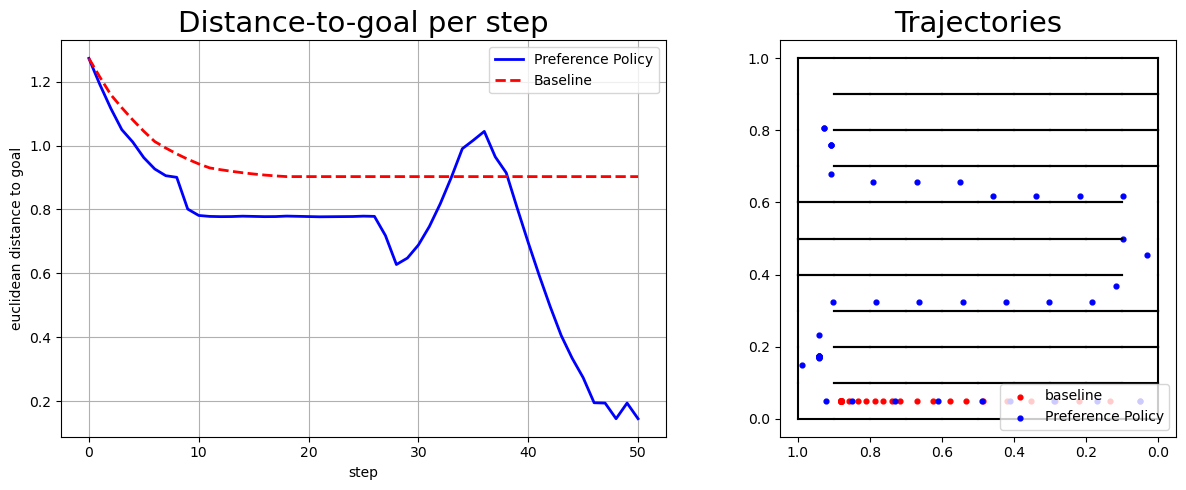

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from maze import Maze
from maze_env import MazeEnv, draw_map, PolicyNetwork, intersect


def best_improving_action(env, acts, ref_metric, tol=1e-6):
    """
    Return the first action that reduces the reference metric by at least `tol`.
    Here `ref_metric` is the current distance-to-goal; we accept an action
    if the next state's distance-to-goal is smaller by ≥ tol. If none improve,
    return None.
    """
    best_a, best_val = None, ref_metric
    for a in acts:
        dx = a[0] * np.cos(a[1] * np.pi) * env.dt
        dy = a[0] * np.sin(a[1] * np.pi) * env.dt
        s1 = env.state + np.array([dx, dy])

        val = np.linalg.norm(env.goal - s1)

        # Skip immediately if the move collides
        if env.point_collision(s1[0], s1[1]):
            continue

        if val < best_val - tol:
            best_val, best_a = val, a

    return best_a


def rollout(env, policy_fn, max_steps=500):
    """
    Roll out a policy `policy_fn(env) -> action` for up to `max_steps`.
    Returns:
      - trajectory array of states
      - list of distances to goal per step
      - step index when goal reached (or -1 if never reached)
    """
    if max_steps is None:
        max_steps = env.horizon
    env.reset(state=start.copy())
    traj, dists = [env.state.copy()], [np.linalg.norm(env.goal - env.state)]

    goal_step = -1  # default = not reached

    for step in range(max_steps):
        a = policy_fn(env)
        state, _, _, _, _ = env.step(action=a, epsilon_goal=0.106)
        traj.append(state.copy())
        dists.append(np.linalg.norm(env.goal - state))
        print(f"Distance: {np.linalg.norm(env.goal - state)}")
        if np.linalg.norm(env.goal - state) < 0.106:
            print(f"✔️ Goal reached in {step+1} steps")
            goal_step = step + 1

    print("❌ Horizon reached without hitting the goal")
    return np.array(traj), dists, goal_step


def policy_dist_safe(env, tol=1e-6):
    """
    Greedy policy on distance-to-goal that stays put if no action improves.
    """
    acts = candidate_actions()
    cur_d = np.linalg.norm(env.goal - env.state)
    a = best_improving_action(env, acts, cur_d, tol=tol)
    return a if a is not None else np.zeros(2, dtype=np.float32)


def to_std(x: torch.Tensor) -> torch.Tensor:
    """
    Normalize tensor `x` using env_dpo statistics (mean/std on the correct device).
    """
    return (x - env_dpo._mean) / env_dpo._std


# -------------------------------
# 1) Environment + DPO policy
# -------------------------------
hidden_dim = 256
num_layers = 4
dropout_prob = 0.05

start = np.array([0.05, 0.05])
maze = Maze(10, 10, 0, 0)
env_dpo = MazeEnv(
    sz=10, maze=maze, start=start, goal=np.array([0.95, 0.95]),
    reward="distance", dt=0.15, horizon=horizon, slide=1,
    use_dpo=True, dpo_model_path=dpo_path,
    hidden_dim=hidden_dim, num_layers=num_layers, dropout_prob=dropout_prob
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Training-time normalization constants (used for inference too)
norm = np.load("norm_stats.npz")
MEAN = norm["mean"].astype(np.float32)            # shape (2,)
STD  = norm["std"].astype(np.float32) + 1e-8      # avoid div-by-zero


def get_norm_tensors(device):
    """
    Cache and return (mean, std) tensors on the requested device.
    """
    if not hasattr(get_norm_tensors, "_cache"):
        get_norm_tensors._cache = {}
    if device not in get_norm_tensors._cache:
        get_norm_tensors._cache[device] = (
            torch.tensor(MEAN, device=device),
            torch.tensor(STD,  device=device),
        )
    return get_norm_tensors._cache[device]


def _std(x: torch.Tensor) -> torch.Tensor:
    """
    Normalize `x` using device-resident mean/std tensors.
    """
    mean_t, std_t = get_norm_tensors(x.device)
    return (x - mean_t) / std_t


def is_legal(env, s_from, s_to, n=4):
    """
    Return False if ANY intermediate point between s_from and s_to touches a wall.
    Also verify the full segment does not intersect a wall.
    """
    alphas = np.linspace(0.0, 1.0, n)
    for a in alphas:
        p = (1 - a) * s_from + a * s_to
        if env.point_collision(p[0], p[1]):
            return False
    return not env.segment_collision(s_from, s_to)


# -------------------------------
# 2) Policies
# -------------------------------
angles = np.linspace(-1, 1, 32, endpoint=False, dtype=np.float32)
speeds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]

# Finer low-speed actions for tight spaces
fine = [0.002, 0.005, 0.008]
speeds = fine + speeds

# Add cell-size-scaled speeds (to align with grid resolution)
cell = 1.0 / env_dpo.sz
speeds = [0.5 * cell / env_dpo.dt, 0.8 * cell / env_dpo.dt, cell / env_dpo.dt] + speeds


def candidate_actions():
    """
    Return an (N,2) array of actions [speed, angle], angle ∈ [-1,1] -> scaled by π at use.
    """
    a, s = np.meshgrid(angles, speeds)
    return np.stack([s.ravel(), a.ravel()], axis=1)


def policy_dpo(env):
    """
    One-step DPO policy: score all next states with the trained network and
    pick the argmax.
    """
    acts = candidate_actions()
    next_states_raw = []
    for a in acts:
        dx = a[0] * np.cos(a[1] * np.pi) * env.dt
        dy = a[0] * np.sin(a[1] * np.pi) * env.dt
        next_states_raw.append(env.state + np.array([dx, dy]))

    x = torch.tensor(next_states_raw, dtype=torch.float32, device=device)
    x_std = _std(x)
    with torch.no_grad():
        scores = env.policy_net(x_std).cpu().numpy().squeeze()
    return acts[np.argmax(scores)]


def policy_dpo_safe(env, tol_val=1e-3):
    """
    Select the highest-scoring non-colliding action. If several actions tie
    at the top score, use distance-to-goal as tie-breaker. If *all* collide,
    return (0, 0).
    """
    acts = candidate_actions()

    legal = [
        a for a in acts
        if is_legal(
            env, env.state,
            env.state + a[0] * env.dt * np.array([np.cos(a[1] * np.pi), np.sin(a[1] * np.pi)])
        )
    ]
    print(f"step {env.counter:3d}  legal={len(legal):3d}")

    # Vectorized next states for all actions
    next_states = env.state + np.stack(
        [
            acts[:, 0] * np.cos(acts[:, 1] * np.pi) * env.dt,
            acts[:, 0] * np.sin(acts[:, 1] * np.pi) * env.dt,
        ],
        axis=1,
    )

    # Score with the network
    with torch.no_grad():
        scores = env.policy_net(
            to_std(torch.as_tensor(next_states, dtype=torch.float32, device=env.device))
        ).cpu().numpy().squeeze()

    # Sort actions by descending score
    order = np.argsort(scores)[::-1]

    # Tie-handling among the best-scoring actions
    best_score = scores[order[0]]
    best_idxs = order[scores[order] == best_score]

    if len(best_idxs) > 1:
        best_d, best_a = np.inf, None
        for idx in best_idxs:
            nx, ny = next_states[idx]
            if is_legal(env, env.state, np.array([nx, ny])):
                d = np.linalg.norm(env.goal - np.array([nx, ny]))
                if d < best_d:
                    best_d, best_a = d, acts[idx]
        if best_a is not None:
            return best_a

    # Otherwise, take the best-scoring legal action
    for idx in order:
        nx, ny = next_states[idx]
        if is_legal(env, env.state, np.array([nx, ny])):
            return acts[idx]

    # Fallback: no legal move
    return np.zeros(2, dtype=np.float32)


def lookahead_action(env, depth=4, beam_width=8):
    """
    Beam-search lookahead of length `depth`. Keeps `beam_width` best branches
    (by network score) per level and returns the first action of the best branch.
    """
    acts = candidate_actions()
    start_val = env.evaluate_state_with_dpo(env.state)

    beam = []
    for a in acts:
        nx = env.state + a[0] * env.dt * np.array([np.cos(a[1] * np.pi), np.sin(a[1] * np.pi)])
        if env.point_collision(*nx):
            continue
        val = env.evaluate_state_with_dpo(nx)
        beam.append((val, a, nx))
    beam.sort(key=lambda x: x[0], reverse=True)
    beam = beam[:beam_width]

    for _ in range(depth - 1):
        new_beam = []
        for _, first_a, cur_s in beam:
            for a in acts:
                nx = cur_s + a[0] * env.dt * np.array([np.cos(a[1] * np.pi), np.sin(a[1] * np.pi)])
                if env.point_collision(*nx):
                    continue
                val = env.evaluate_state_with_dpo(nx)
                new_beam.append((val, first_a, nx))
        if not new_beam:
            break
        new_beam.sort(key=lambda x: x[0], reverse=True)
        beam = new_beam[:beam_width]

    best_val, best_a, _ = beam[0]
    if best_val <= start_val + 1e-4:
        return np.zeros(2, dtype=np.float32)
    return best_a


def best_action_two_steps(
    env,
    beam_speeds=None,   # kept for compatibility; unused here
    printf=True,
    tol_val=1e-3,       # equality tolerance on network score
    tol_dist=1e-3       # equality tolerance on distance-to-goal (~1 mm)
):
    """
    Two-step lookahead:
      - For each legal first step s1, choose the best s2 (by network score).
      - Keep the first action of the best (s1, s2) branch that is legal.
      - Tie-break by smaller distance-to-goal.
      - Fallback to best single-step if no two-step branch is legal.
    """
    acts = candidate_actions()

    if printf:
        legal = [
            a for a in acts if is_legal(
                env, env.state,
                env.state + a[0] * env.dt * np.array([np.cos(a[1] * np.pi), np.sin(a[1] * np.pi)])
            )
        ]
        print(f"step {env.counter:3d}  legal={len(legal):3d}")

    # Precompute all candidate s1
    next_states_1 = env.state + np.stack(
        [
            acts[:, 0] * np.cos(acts[:, 1] * np.pi) * env.dt,
            acts[:, 0] * np.sin(acts[:, 1] * np.pi) * env.dt,
        ],
        axis=1,
    )

    cur_d = float(np.linalg.norm(env.goal - env.state))

    best_two_score, best_two_d = -np.inf, cur_d
    best_two_action = None
    best_one_score, best_one_d = -np.inf, cur_d
    best_one_action = None

    for i, s1 in enumerate(next_states_1):
        if not is_legal(env, env.state, s1):
            continue

        s2_all = s1 + np.stack(
            [
                acts[:, 0] * np.cos(acts[:, 1] * np.pi) * env.dt,
                acts[:, 0] * np.sin(acts[:, 1] * np.pi) * env.dt,
            ],
            axis=1,
        )

        with torch.no_grad():
            scores = env.policy_net(
                _std(torch.tensor(s2_all, dtype=torch.float32, device=env.device))
            ).cpu().numpy()

        idx_best2 = scores.argmax()
        two_score = float(scores[idx_best2])
        s2_best = s2_all[idx_best2]

        # (A) Update two-step record only if s2 is legal; tie-break on smaller d2
        if is_legal(env, s1, s2_best):
            d2 = float(np.linalg.norm(env.goal - s2_best))
            better_score = two_score > best_two_score + tol_val
            tie_score = abs(two_score - best_two_score) <= tol_val
            better_dist = d2 < best_two_d - tol_dist
            if better_score or (tie_score and better_dist):
                best_two_score, best_two_d = two_score, d2
                best_two_action = acts[i]

        # (B) Always update one-step fallback record
        d1 = float(np.linalg.norm(env.goal - s1))
        better_score = two_score > best_one_score + tol_val
        tie_score = abs(two_score - best_one_score) <= tol_val
        better_dist = d1 < best_one_d - tol_dist
        if better_score or (tie_score and better_dist):
            best_one_score, best_one_d = two_score, d1
            best_one_action = acts[i]

    if best_two_action is not None:
        return best_two_action
    if best_one_action is not None:
        return best_one_action

    print(f"-- step {env.counter:3d}  no legal move, agent stays still")
    return np.zeros(2, dtype=np.float32)


def policy_dist(env):
    """
    Baseline greedy policy on Euclidean distance-to-goal (collision-aware).
    """
    acts = candidate_actions()
    best, best_d = None, np.inf
    for a in acts:
        dx = a[0] * np.cos(a[1] * np.pi) * env.dt
        dy = a[0] * np.sin(a[1] * np.pi) * env.dt
        s = env.state + np.array([dx, dy])
        d = np.linalg.norm(env.goal - s)
        if d < best_d and is_legal(env, env.state, s):
            best_d, best = d, a
    return best if best is not None else acts[0]


# -------------------------------
# 3) Run both rollouts
# -------------------------------
traj_dpo, dist_dpo, iter_dpo = rollout(env_dpo, best_action_two_steps, max_steps=horizon)

env_base = MazeEnv(
    sz=10, maze=maze, start=start, goal=np.array([0.95, 0.95]),
    reward="distance", dt=0.15, horizon=horizon_base, slide=1, use_dpo=False
)
traj_base, dist_base, iter_base = rollout(env_base, policy_dist_safe, max_steps=horizon_base)

# -------------------------------
# 4) Comparative plotting
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Distance-to-goal vs. step
axes[0].plot(dist_dpo,  label="Preference Policy", lw=2, color="blue")
axes[0].plot(dist_base, label="Baseline",          lw=2, ls="--", color="red")
axes[0].set_xlabel("step")
axes[0].set_ylabel("euclidean distance to goal")
axes[0].set_title("Distance-to-goal per step", fontsize=21)
axes[0].legend()
axes[0].grid(True)

# Trajectories
draw_map(1 / env_dpo.sz, env_dpo.maze, ax=axes[1], alpha=1.0)

# Baseline trajectory (solid red)
if len(traj_base) > 0:
    axes[1].scatter(traj_base[:, 0], traj_base[:, 1], color="red", s=12, label="Baseline")
else:
    axes[1].scatter([], [], color="red", s=12, label="Baseline")

# DPO trajectory (solid blue)
if len(traj_dpo) > 0:
    axes[1].scatter(traj_dpo[:, 0], traj_dpo[:, 1], color="blue", s=12, label="Preference Policy")
else:
    axes[1].scatter([], [], color="blue", s=12, label="Preference Policy")

axes[1].invert_xaxis()
axes[1].set_aspect("equal")
axes[1].set_title("Trajectories", fontsize=21)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


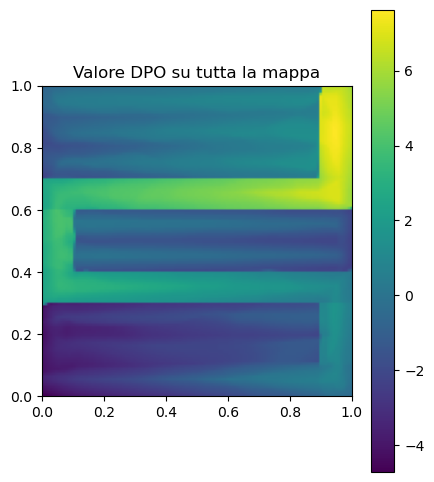

In [3]:
def plot_value_heatmap(env, n=120):
    # campiona n×n punti su tutta la mappa e valuta la rete DPO
    xs = np.linspace(0, 1, n)
    ys = np.linspace(0, 1, n)
    xx, yy = np.meshgrid(xs, ys)
    pts = np.stack([xx.ravel(), yy.ravel()], axis=1)
    with torch.no_grad():
        vals = env.policy_net(
            (torch.tensor(pts, device=env.device, dtype=torch.float32)
             - env._mean) / env._std
        ).cpu().numpy().reshape(n, n)
    plt.figure(figsize=(5,6))
    plt.title("Valore DPO su tutta la mappa")
    plt.imshow(vals, origin="lower", extent=[0,1,0,1], cmap="viridis")
    plt.colorbar(); plt.show()

plot_value_heatmap(env=env_dpo)

1) Enviroment (preference maze - maze laby with S)
2) greedy fails 
3) the way in which we define the preference function influence a lot the DPO